In [1]:
import json, os, itertools
from collections import defaultdict
import gurobipy as gp
import pandas as pd
import numpy as np

BASE_DIR = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json"   
edge_fp   = os.path.join(BASE_DIR, "edges.json")
route_fp  = os.path.join(BASE_DIR, "routes_nodes.json")
demand_fp = os.path.join(BASE_DIR, "demand.json")
dept_fp   = os.path.join(BASE_DIR, "dep_time.json")

In [2]:
# 0-b. 고정 파라미터
T        = 12
max_wait = 0
CAPACITY = 30
failed_edges = {"e81"}
w1, w2, w3 = 1000, 1000, 10
BIG_M = 10**6
SINK  = "SINK"
W_ROUTE = 100

# 0-c. JSON 로드
with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

with open(route_fp, encoding="utf-8") as f:
    routes_nodes = json.load(f)

with open(dept_fp, encoding="utf-8") as f:
    dep_time = {tr: int(t) for tr, t in json.load(f).items()}

with open(demand_fp, encoding="utf-8") as f:
    dem_raw = json.load(f)
demand = {tr: [(o, d, float(q)) for o, d, q in lst] for tr, lst in dem_raw.items()}

trains = list(routes_nodes)
nodes  = {n for _, (s, d, _) in edges.items() for n in (s, d)}
nodes.add(SINK)

# ----- 시간-확장 아크 ---------------------------------------------------
arc_list = []                       # (from,to,eid,tau,t0,t1)
for eid, (src, dst, tau) in edges.items():
    if eid in failed_edges: continue
    for t in range(T + 1 - tau):
        arc_list.append((f"{src}^{t}", f"{dst}^{t+tau}", eid, tau, t, t+tau))

for n in nodes - {SINK}:
    for w in range(1, max_wait+1):
        for t in range(T + 1 - w):
            arc_list.append((f"{n}^{t}", f"{n}^{t+w}", f"w_{n}_{w}", w, t, t+w))

for n in nodes - {SINK}:
    for t in range(T+1):
        arc_list.append((f"{n}^{t}", f"{SINK}^{t}", f"dummy_{n}", 0, t, t))

arc_idx = {info: i for i, info in enumerate(arc_list)}

# ───────────────── 캐싱: arc → 노드·시각 별 in/out ─────────────────
out_arcs = defaultdict(list)   # (node,t) → [arcIdx…]
in_arcs  = defaultdict(list)   # (node,t) → [arcIdx…]
node_in_arcs  = defaultdict(list)   # 노드 방문용
node_out_arcs = defaultdict(list)

for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
    n_fr, tt_fr = fr.split("^"); tt_fr = int(tt_fr)
    n_to, tt_to = to.split("^"); tt_to = int(tt_to)

    out_arcs[(n_fr, tt_fr)].append(k)
    in_arcs [(n_to, tt_to)].append(k)

    if not eid.startswith(("w_", "dummy")):      # s[tr,n] 계산용
        node_out_arcs[n_fr].append(k)
        node_in_arcs [n_to].append(k)


# ----- 예정 도착시각 ----------------------------------------------------
sched = {}
for tr, path in routes_nodes.items():
    t, arr = 0, {path[0]: dep_time[tr]}
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        t += edges[eid][2]; arr[v] = dep_time[tr] + t
    sched[tr] = arr

q_r = {tr: sum(q for *_, q in demand[tr]) for tr in trains}


In [3]:
# ===== (NEW) 계획 엣지 / blocked / 접미 실패 / 종료 허용노드 =====
uv2eid = {}
dup_keys = set()
for eid, (s, d, _) in edges.items():
    key = (s, d)
    if key in uv2eid and uv2eid[key] != eid:
        dup_keys.add(key)  # 동일 (s,d)에 eid가 여러 개면 체크
    else:
        uv2eid[key] = eid

if dup_keys:
    # 필요시 여기서 raise 하거나, 첫 번째 eid만 쓰고 경고 출력
    print(f"[warn] multiple eids share the same (u,v): {sorted(list(dup_keys))[:5]} ...")

def planned_eids_of(tr):
    """열차 tr의 계획 경로 상 (u,v)들에 대한 eid 리스트를 O(1)로 반환"""
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid.get((u, v))
        if eid is None:
            raise KeyError(f"No edge (u={u} -> v={v}) found in edges; check routes_nodes or edges.json")
        eids.append(eid)
    return eids

# 이제 O(1)로 추출
planned_eids = {tr: planned_eids_of(tr) for tr in trains}

# 이 열차의 계획경로가 실패엣지를 포함하면 blocked=1
blocked = {tr: int(any(e in failed_edges for e in planned_eids[tr]))
           for tr in trains}

# 접미 실패 플래그 F_{r,i}와 reach_r, 그리고 노드별 종료 허용 allow_stop[(tr,n)]
allow_stop = {}
reach = {}
for tr in trains:
    path = routes_nodes[tr]           # [n0, n1, ..., nL]
    eids = planned_eids[tr]           # [e0, e1, ..., e_{L-1}]
    L = len(path) - 1
    # 종착 스케줄이 T 이내인지
    t_sched_term = sched[tr].get(path[-1], 10**9)
    reach[tr] = int(t_sched_term <= T)

    # 노드 기준 접미 실패 플래그 F_{r,i}
    suffix_failed = [0]*(L+1)         # index = node i
    hit = 0
    for i in range(L-1, -1, -1):      # edge index i maps to node i
        if eids[i] in failed_edges:
            hit = 1
        suffix_failed[i] = hit
    # suffix_failed[L] = 0 (종착 노드)

    # 종료 허용 노드: path[1:] (origin 제외)
    for i in range(1, L+1):
        n = path[i]
        if i == L:                             # 종착은 항상 허용
            allow = 1
        elif reach[tr] == 0:                   # 종착이 T 이후면 완화
            allow = 1
        else:                                  # 종착이 T 이내면 접미 실패가 있어야 조기 종료
            allow = suffix_failed[i]
        allow_stop[(tr, n)] = int(allow)

In [4]:
def build_base_model():

    m = gp.Model(); m.Params.OutputFlag = 1
    nA, nT = len(arc_list), len(trains)
    x = m.addVars(nA, nT, vtype=gp.GRB.BINARY, name="x")
    h = m.addVars(trains, vtype=gp.GRB.BINARY, name="h")
    y = {(tr, n): m.addVar(vtype=gp.GRB.BINARY) for tr in trains for n in routes_nodes[tr][1:]}
    s = {(tr, n): m.addVar(vtype=gp.GRB.BINARY) for tr in trains for n in nodes - {SINK}}
    z = {(tr,o,d): m.addVar(vtype=gp.GRB.BINARY) for tr in trains for (o,d,_) in demand[tr]}
    delta = {(tr,o,d): m.addVar(lb=0) for tr in trains for (o,d,_) in demand[tr]}
    t_arr = {(tr, n): m.addVar(lb=0, ub=T, vtype=gp.GRB.INTEGER)
             for tr in trains for n in nodes - {SINK}}
    
    # === (NEW) 고장 시엔 무제한 우회 가능, 다만 우회 1개당 벌점 W_ROUTE가 들어감
    real_eids = {eid for (_,_,eid,_,_,_) in arc_list if not str(eid).startswith(("w_","dummy"))}
    u_eid = {}  # key: (tr, eid)

    for tr_i, tr in enumerate(trains):
        P = set(planned_eids[tr])  
        for eid in real_eids:
            if eid in P: 
                continue  
            u_eid[(tr, eid)] = m.addVar(vtype=gp.GRB.BINARY, name=f"u_eid[{tr},{eid}]")

            for k, (fr, to, e, *_ ) in enumerate(arc_list):
                if e == eid:
                    m.addConstr(x[k, tr_i] <= u_eid[(tr, eid)])

    for tr in trains:
        if blocked[tr] == 0:
            m.addConstr(gp.quicksum(u_eid[key] for key in u_eid.keys() if key[0]==tr) == 0)
        else:
            pass

    # (2) 출발-flow
    for tr_i, tr in enumerate(trains):
        r_o, t_dep = routes_nodes[tr][0], dep_time[tr]
        idx_out = out_arcs[(r_o, t_dep)]       
        m.addConstr(x.sum(idx_out, tr_i) == h[tr])

    # (5) 노드-시간 보존
    for tr_i, tr in enumerate(trains):
        r_o, t_dep = routes_nodes[tr][0], dep_time[tr]
        for n in nodes - {SINK}:
            for t in range(T+1):
                inflow  = x.sum(in_arcs[(n, t)],  tr_i)
                outflow = x.sum(out_arcs[(n, t)], tr_i)
                if (n == r_o) and (t == t_dep):
                    m.addConstr(outflow - inflow == h[tr])
                else:
                    m.addConstr(inflow == outflow)

    # === (NEW) 종료 허용 노드만 y 가능 (또는 더미x 가능)
    for tr_i, tr in enumerate(trains):
        for n in routes_nodes[tr][1:]:
            if allow_stop[(tr, n)] == 0:
                y[tr, n].UB = 0
                idx_dum = [i for i,(fr,to,eid,_,_,_) in enumerate(arc_list) if eid == f"dummy_{n}"]
                for k in idx_dum:
                    x[k, tr_i].UB = 0

    # terminal & dummy
    for tr_i, tr in enumerate(trains):
        cand = routes_nodes[tr][1:]
        m.addConstr(gp.quicksum(y[tr, n] for n in cand) == h[tr])
        for n in cand:
            idx_dum = [arc_idx[a] for a in arc_list if a[2] == f"dummy_{n}"]
            m.addConstr(x.sum(idx_dum, tr_i) == y[tr, n])

    # s (visit)
    for (tr, n), var in s.items():
        tr_i = trains.index(tr)
        idx = node_out_arcs[n] + node_in_arcs[n] 
        flow = x.sum(idx, tr_i)
        m.addConstr(flow >= var)
        m.addConstr(flow <= BIG_M * var)
        
    # z-logic & delta
    for tr in trains:
        for (o, d, q) in demand[tr]:
            m.addConstr(z[tr, o, d] <= s[tr, o])
            m.addConstr(z[tr, o, d] <= s[tr, d])
            m.addConstr(z[tr, o, d] >= s[tr, o] + s[tr, d] - 1)
            m.addConstr(z[tr, o, d] <= h[tr])

    for tr_i, tr in enumerate(trains):
        for k, (fr, to, eid, *_ ) in enumerate(arc_list):
            if eid.startswith(("w_", "dummy")): continue
            n_to, tt = to.split("^"); tt = int(tt)
            m.addConstr(t_arr[tr, n_to] >= tt - BIG_M * (1 - x[k, tr_i]))
            m.addConstr(t_arr[tr, n_to] <= tt + BIG_M * (1 - x[k, tr_i]))
        for (o, d, q) in demand[tr]:
            sched_t = sched[tr].get(d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t - BIG_M * (1 - z[tr, o, d]))
            m.addConstr(delta[tr, o, d] <= BIG_M * z[tr, o, d])

    # Objective function
    obj  = gp.quicksum(w1 * q_r[tr] * (1 - h[tr]) for tr in trains)
    obj += gp.quicksum(w2 * q * (1 - z[tr, o, d]) for tr in trains for (o, d, q) in demand[tr])
    obj += gp.quicksum(w3 * q * delta[tr, o, d] for tr in trains for (o, d, q) in demand[tr])
    
    #  === (NEW)        
    if u_eid: 
        obj += W_ROUTE * gp.quicksum(u_eid.values())

    m.setObjective(obj)
    return m, x, h, delta, z

# cap_map: (eid,tt) → [arcIdx …]
cap_map = defaultdict(list)
for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
    if eid.startswith(("w_", "dummy")): continue
    for tt in range(t0, t1):
        cap_map[(eid, tt)].append(k)

In [5]:
working_set, sol_prev = set(), None
MAX_ITER, EPS, SHOW = 40, 1e-6, 30

for it in range(MAX_ITER):
    base, xvar, hvar, delta, z = build_base_model()

    constr_refs = {}
    for (eid, tt) in working_set:
        expr = gp.quicksum(xvar[idx, ti] for idx in cap_map[(eid, tt)]
                           for ti in range(len(trains)))
        constr_refs[(eid, tt)] = base.addConstr(expr <= CAPACITY,
                                               name=f"cap_{eid}_{tt}")

    if sol_prev:
        for (idx, ti), v in sol_prev.items():
            xvar[idx, ti].Start = v

    base.optimize()
    if base.Status != gp.GRB.OPTIMAL:
        raise RuntimeError("non-optimal")

    x_val = {(idx, ti): round(xvar[idx, ti].X)
         for idx in range(len(arc_list))
         for ti  in range(len(trains))}
    
    # ③-c violation search
    x_mat = np.zeros((len(arc_list), len(trains)), dtype=np.uint8)
    for (idx, ti), v in x_val.items():      # x_val 은 아래에서 다시 만듦
        if v: x_mat[idx, ti] = 1
    cap_keys   = list(cap_map)                         # [(eid,tt), …]
    cap_idxarr = [np.fromiter(cap_map[k], dtype=int)   # each → np.array
                for k in cap_keys]
    viol = set()
    for k, idx_arr in zip(cap_keys, cap_idxarr):
        if x_mat[idx_arr].sum() > CAPACITY + EPS:
            viol.add(k)

    # ③-d negative dual search
    neg_pi = set()
    lp = base.relax(); lp.optimize()
    if lp.Status == gp.GRB.OPTIMAL:
        for key, c in constr_refs.items():
            if c.Pi < -EPS: neg_pi.add(key)
            
    # ③-e working-set update
    updated = False
    for k in viol:
        if k not in working_set: working_set.add(k); updated = True
    for k in neg_pi:
        if k in working_set: working_set.remove(k); updated = True

    ws = sorted(working_set)
    print(f"[Iter {it}] |W|={len(ws)}  preview={ws[:SHOW]}")
    print(f"          add={len(viol)} drop={len(neg_pi)}")
    sol_prev = x_val
    if not updated:
        print("↳ converged"); break
else:
    print("⚠ MAX_ITER reached")

Set parameter Username
Set parameter LicenseID to value 2637066
Academic license - for non-commercial use only - expires 2026-03-16
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 820451 rows, 379856 columns and 2940643 nonzeros
Model fingerprint: 0xb44ddaa3
Variable types: 1867 continuous, 377989 integer (369694 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+02, 1e+06]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 1.588621e+08
Presolve removed 806300 rows and 372880 columns
Presolve time: 0.93s
Presolved: 14151 rows, 6976 columns, 42046 nonzeros
Variable types: 0 continuous, 6976 integer (5772 binary)
Performing another presolve...
Presolv

In [6]:
# ========== Cell 5 (교체) ==========
pd.set_option('display.max_rows', None)

# 1) Timetable (요약만 표시)
rows = []
for tr_i, tr in enumerate(trains):
    if hvar[tr].X < 0.5:
        rows.append([tr, '-', '-', '-', '-', 'Cancelled'])
        continue
    legs = [(int(arc_list[k][0].split("^")[1]),
             arc_list[k][0].split("^")[0],
             arc_list[k][1].split("^")[0],
             int(arc_list[k][1].split("^")[1]),
             arc_list[k][2])
            for k in range(len(arc_list))
            if xvar[k, tr_i].X > 0.5 and not arc_list[k][2].startswith(("w_", "dummy"))]
    legs.sort(key=lambda v: v[0])
    for dep, frm, to, arr, eid in legs:
        rows.append([tr, frm, dep, to, arr, eid])

df = pd.DataFrame(rows, columns=["Train", "From", "Dep", "To", "Arr", "Edge"])
print("\n=== Timetable (head) ===")
display(df.head(3))

# 2) 유틸리티
def planned_path_and_eids(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        eids.append(eid)
    return path, eids

def build_actual_legs(tr):
    tr_i = trains.index(tr)
    legs = [(int(arc_list[k][0].split("^")[1]),
             arc_list[k][0].split("^")[0],
             arc_list[k][1].split("^")[0],
             int(arc_list[k][1].split("^")[1]),
             arc_list[k][2])
            for k in range(len(arc_list))
            if xvar[k, tr_i].X > 0.5 and not arc_list[k][2].startswith(("w_", "dummy"))]
    legs.sort(key=lambda v: v[0])
    return legs

def path_nodes_from_legs(legs):
    if not legs: return []
    nodes = [legs[0][1]]
    for _, _, to, _, _ in legs:
        nodes.append(to)
    return nodes

def actual_arrival_map(legs):
    """노드별 최초 도착시각 dict"""
    amap = {}
    for _, frm, to, arr, _ in legs:
        if to not in amap or arr < amap[to]:
            amap[to] = arr
    if legs:
        # 출발 노드는 dep 시각(legs[0][2]==to가 아니라, from의 dep)도 기록할 수 있지만
        # 지연 판정엔 주로 도착 노드가 쓰임
        pass
    return amap

# 3) 상태 요약 (T-제한 비교)
stat_rows = []
for tr in trains:
    departed = (hvar[tr].X >= 0.5)
    planned_path, planned_eids = planned_path_and_eids(tr)
    planned_terminal = planned_path[-1]
    planned_terminal_sched = sched[tr].get(planned_terminal, None)

    if not departed:
        stat_rows.append({
            "Train": tr, "Departed": False, "ArrivedInHorizon": False,
            "PlannedTerminal": planned_terminal,
            "ActualTerminal": None,
            "Delay(min)": None,                 # 도착 안 했으므로 없음
            "HorizonDelay(min)": None,          # T-기준 prefix 지연
            "Truncated": False, "Rerouted": False,
            "Status": "Cancelled"
        })
        continue

    # 실제 운행 legs / 경로
    legs = build_actual_legs(tr)
    actual_nodes = path_nodes_from_legs(legs)
    actual_eids  = [e for *_, e in legs]
    arr_map      = actual_arrival_map(legs)
    actual_terminal = actual_nodes[-1] if actual_nodes else None
    actual_arrival  = max(arr for *_, arr, _ in legs) if legs else None

    # 계획 prefix (T 이내에 '완료'되는 엣지들만)
    # sched[tr][node]는 그 노드 예정 도착시각.
    # node0=origin은 dep_time, 이후 node1.. 의 예정도착이 있음.
    # T 이내인 마지막 노드를 찾아 prefix를 정함.
    prefix_last_idx = 0  # 최소 origin(=index 0)
    for i, node in enumerate(planned_path):
        t_planned = sched[tr].get(node, None)
        if t_planned is not None and t_planned <= T:
            prefix_last_idx = i
    planned_prefix_nodes = planned_path[:prefix_last_idx+1]
    planned_prefix_eids  = planned_eids[:max(0, prefix_last_idx)]

    # 도착/Truncated 판정 (목적지의 예정 도착이 T 이내일 때만 Truncated 고려)
    arrived_in_horizon = (actual_terminal == planned_terminal) and (actual_arrival is not None) and (actual_arrival <= T)
    if planned_terminal_sched is not None and planned_terminal_sched <= T:
        truncated = (not arrived_in_horizon)
    else:
        truncated = False  # 원래 T 이후 도착 예정이면 Truncated로 보지 않음

    # 재루팅: T 이내 계획 prefix vs 실제 사용 prefix 비교
    # 실제 사용 엣지(actual_eids)는 모두 T 이내에 끝난 아크들로 구성(모델링상 t1<=T)
    # → 계획 prefix 길이와 겹치는 구간까지 비교
    common = min(len(actual_eids), len(planned_prefix_eids))
    rerouted = (actual_eids[:common] != planned_prefix_eids[:common])
    # 만약 계획 prefix가 더 길고, 실제가 prefix 길이만큼 동일한 채 더 못 갔다면
    # 단순 '지연/진행중'일 수 있으므로 여기서는 rerouted로 보지 않음.

    # Delay 계산
    delay_min = None
    horizon_delay_min = None

    # ① 목적지가 T 이내 도착 예정이었고, 실제도 T 이내 도착했다면 → 목적지 기준 지연
    if planned_terminal_sched is not None and planned_terminal_sched <= T and arrived_in_horizon:
        delay_min = max(0, actual_arrival - planned_terminal_sched)

    # ② T 이내 계획 prefix의 '마지막 계획 노드'에서의 지연(도달했을 때만)
    if planned_prefix_nodes:
        last_plan_node = planned_prefix_nodes[-1]
        t_plan_last    = sched[tr].get(last_plan_node, None)
        t_act_last     = arr_map.get(last_plan_node, None)
        if (t_plan_last is not None) and (t_act_last is not None):
            horizon_delay_min = max(0, t_act_last - t_plan_last)

    # 상태 라벨
    if not departed:
        status = "Cancelled"
    elif truncated:
        status = "Truncated"
    elif rerouted:
        status = "Rerouted"
    elif (planned_terminal_sched is not None and planned_terminal_sched <= T and delay_min and delay_min > 0) \
         or (horizon_delay_min is not None and horizon_delay_min > 0):
        status = "Delayed"
    else:
        # 목적지가 T 이후 예정이라 아직 진행 중인 경우
        if planned_terminal_sched is not None and planned_terminal_sched > T and not arrived_in_horizon:
            status = "On-time & in-progress"
        else:
            status = "On-time & complete"

    stat_rows.append({
        "Train": tr,
        "Departed": True,
        "ArrivedInHorizon": arrived_in_horizon,
        "PlannedTerminal": planned_terminal,
        "ActualTerminal": actual_terminal,
        "Delay(min)": delay_min,
        "HorizonDelay(min)": horizon_delay_min,
        "Truncated": truncated,
        "Rerouted": rerouted,
        "Status": status
    })

df_stat = pd.DataFrame(stat_rows, columns=[
    "Train","Departed","ArrivedInHorizon","PlannedTerminal","ActualTerminal",
    "Delay(min)","HorizonDelay(min)","Truncated","Rerouted","Status"
])
print("\n=== Train status summary — horizon-aware (T-based) ===")
display(df_stat.head(3))



=== Timetable (head) ===


,Train,From,Dep,To,Arr,Edge
0,경부고속철도1_1,n4,0,n3,1,e4
1,경부고속철도1_1,n3,1,n1,2,e3
2,경부고속철도1_1,n1,2,n2,3,e1



=== Train status summary — horizon-aware (T-based) ===


,Train,Departed,ArrivedInHorizon,PlannedTerminal,ActualTerminal,Delay(min),HorizonDelay(min),Truncated,Rerouted,Status
0,경부고속철도1_1,True,False,n79,n60,NaN,0.0,False,False,On-time & in-progress
1,경부고속철도1_2,True,False,n79,n60,NaN,0.0,False,False,On-time & in-progress
2,경부고속철도1_3,True,False,n79,n42,NaN,0.0,False,False,On-time & in-progress


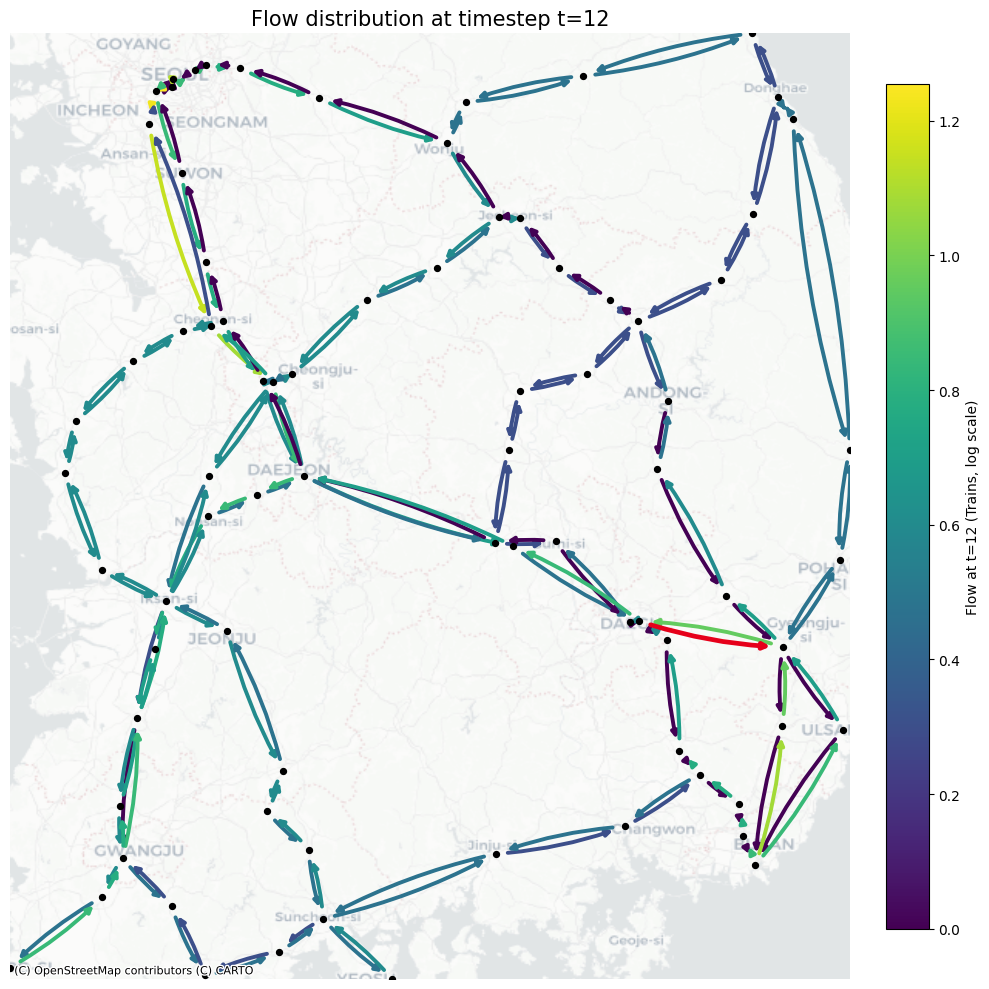

In [7]:
# ============================================================
# timestep_flow_plot.py
# ----------------------
# (1) Gurobi 결과에서 시점별 edge-flow 계산
# (2) QGIS에서 export한 엑셀·JSON으로 좌표·수요 읽기
# (3) contextily + networkx 로 지도 시각화
#     - 엣지가 edge_fp에 존재하면 흐름이 0이어도 "무조건" 그린다
#     - demand에 없거나 흐름이 없는 것은 0으로 처리한다
#     - 컬러 스케일은 0부터 시작
# ============================================================

import json, math, itertools, contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely import wkt
from collections import defaultdict

# ============================================================
# 0. 사용자 설정
# ============================================================
BASE      = Path(r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json")
xlsx_fp   = BASE / "qgis_export.xlsx"              # QGIS export 엑셀
edge_fp   = BASE / "edges.json"                    # 네트워크 엣지
json_fp   = BASE / r"json\demand_fig.json"         # (선택) 기타 참고 JSON
flow_type = "trains"    # "trains" (열차 수) / "pax" (승객수 합)
t_focus    = 12        # 시점
cumulative = True       # True: t<=t_focus 누적 / False: t 구간 내만

# ============================================================
# 1. (필요 시) Gurobi 결과 로딩 안내
#    - 이 스크립트는 x_val, arc_list, trains, demand 변수가
#      메모리에 있다고 가정. 없으면 아래처럼 불러오도록 구현하세요.
# ============================================================
# 예) pickle로 저장해두었다면:
# import pickle
# with open("result_vars.pkl", "rb") as f:
#     data = pickle.load(f)
# x_val   = data["x_val"]     # {(arcIdx, trainIdx): 0/1}
# arc_list= data["arc_list"]  # [(from^t, to^t', eid, tau, t0, t1), ...]
# trains  = data["trains"]    # ["T1","T2",...]
# demand  = data["demand"]    # {"T1":[(o,d,q),...], ...}

# ============================================================
# 2. split_node_time 유틸
# ============================================================
def split_node_time(s):
    """
    "n123^7"  → ("n123", 7)
    "n123"    → ("n123", None)
    123       → ("n123", None)
    "SINK"    → ("SINK", None)
    """
    if isinstance(s, (int, np.integer)):
        return f"n{int(s)}", None
    s = str(s)
    if "^" in s:
        node, t = s.split("^", 1)
        return node, int(t)
    if s.isdigit():
        return f"n{int(s)}", None
    return s, None

# ============================================================
# 3. edge_fp 로드 (엣지 목록: 존재하면 0이라도 그릴 기준)
# ============================================================
with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)  # {eid: [src, dst, tau], ...}
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

# (NEW) 실패 엣지의 (u,v) 쌍 만들기 — edges.json의 src/dst는 "n123" 형식이라 G의 노드와 일치
failed_pairs = {(s, d) for eid, (s, d, _) in edges.items() if eid in failed_edges}


# ============================================================
# 4. Gurobi 결과로부터 시점별 flow 집계
#    - x_val에서 1로 선택된 arc만 집계
#    - flow_type=="trains" → 1열차당 +1
#    - flow_type=="pax"    → 그 열차의 총 승객수 q_tot를 더함
#    - 시간필터: cumulative / non-cumulative
# ============================================================
edge_flow_t = defaultdict(float)  # (u,v) -> flow

for (idx, ti), val in x_val.items():
    if val < 0.5:
        continue
    fr_str, to_str, eid = arc_list[idx][:3]
    if eid.startswith(("w_", "dummy")):
        continue

    u_raw, t_dep = split_node_time(fr_str)
    v_raw, t_arr = split_node_time(to_str)
    if t_dep is None or t_arr is None:
        continue

    cond = (t_dep <= t_focus) if cumulative else (t_dep <= t_focus < t_arr)
    if not cond:
        continue

    if flow_type == "trains":
        edge_flow_t[(u_raw, v_raw)] += 1.0
    else:
        tr_name = trains[ti]
        q_tot   = sum(q for _, _, q in demand[tr_name]) if demand.get(tr_name) else 0.0
        edge_flow_t[(u_raw, v_raw)] += float(q_tot)

# ============================================================
# 5. QGIS Export: 노드·엣지 좌표 읽기
# ============================================================
node_df = pd.read_excel(xlsx_fp, sheet_name="NODE", usecols=["node_id", "geometry"])
edge_df = pd.read_excel(xlsx_fp, sheet_name="EDGE",
                        usecols=["edge_id", "from_node_id", "to_node_id", "geometry"])

node_gdf = gpd.GeoDataFrame(
    node_df.assign(geometry=node_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

edge_gdf = gpd.GeoDataFrame(
    edge_df.assign(geometry=edge_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

# 5-A. 노드 좌표 dict
pos = {f"n{int(r.node_id)}": (r.geometry.x, r.geometry.y)
       for r in node_gdf.itertuples(index=False)}

# 5-B. 엣지 (u,v) 쌍 및 양방향 처리 (edge_fp의 존재 기준으로 모두 그림)
edges_bidir = {}
for r in edge_gdf.itertuples(index=False):
    u = f"n{int(r.from_node_id)}"
    v = f"n{int(r.to_node_id)}"
    edges_bidir[(u, v)] = r.geometry

# 반대방향이 없으면 동일 geometry로 보강
for (u, v), geom in list(edges_bidir.items()):
    if (v, u) not in edges_bidir:
        edges_bidir[(v, u)] = geom

# ============================================================
# 6. edge_flow_t에 없는 엣지도 0으로 채워 넣기(누락 방지)
# ============================================================
for (u, v) in edges_bidir.keys():
    if (u, v) not in edge_flow_t:
        edge_flow_t[(u, v)] = 0.0

# ============================================================
# 7. NetworkX 그래프 생성 (모든 엣지를 추가; 0이면 얇고 회색)
# ============================================================
G = nx.DiGraph()
for n, xy in pos.items():
    G.add_node(n, pos=xy)

for (u, v), geom in edges_bidir.items():
    flow = float(edge_flow_t.get((u, v), 0.0))
    G.add_edge(u, v, weight=flow, geom=geom)  # 무조건 추가

# ============================================================
# 8. 색상 매핑 (log 스케일, 0부터)
# ============================================================
flows = [d["weight"] for _, _, d in G.edges(data=True)]
logf  = [math.log10(max(0.0, f) + 1.0) for f in flows]  # f=0 -> 0
vmax  = max(logf) if logf else 1.0
if vmax <= 0:
    vmax = 1.0
norm  = mpl.colors.Normalize(vmin=0.0, vmax=vmax)
cmap  = sns.color_palette("viridis", as_cmap=True)

# ============================================================
# 9. 시각화
# ============================================================
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor("white")

# 9-A. 지도 범위 & 배경
if pos:
    xs, ys = zip(*pos.values())
    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(min(ys), max(ys))
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)

# 9-B. 엣지 그리기 — 일반 먼저, 실패(red) 나중에 가장 위로
# 9-B-1) 일반 엣지 먼저
for (u, v, data) in G.edges(data=True):
    if (u, v) in failed_pairs:
        continue
    f  = float(data["weight"])
    lf = math.log10(f + 1.0)
    color = cmap(norm(lf))
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=2.8, edge_color=[color],
        arrowstyle="-|>", arrowsize=9,
        connectionstyle="arc3,rad=0.07", ax=ax
    )

# 9-C) 노드 (원하는 경우 노드는 실패엣지 아래/위 결정)
nx.draw_networkx_nodes(G, pos, node_size=18, node_color="black", ax=ax)

# 9-B-2) 실패 엣지 마지막(빨강) → 최상단
for (u, v, data) in G.edges(data=True):
    if (u, v) not in failed_pairs:
        continue
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=3.4, edge_color=[(0.9, 0.0, 0.1, 1.0)],  # 빨강
        arrowstyle="-|>", arrowsize=9,
        connectionstyle="arc3,rad=0.07", ax=ax
    )



# 9-D. 컬러바(양의 흐름이 있는 경우만 의미 있음)
if any(f > 0.0 for f in flows):
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    label = "Trains" if flow_type == "trains" else "Passengers"
    cbar.set_label(f"Flow at t={t_focus} ({label}, log scale)")

ax.set_title(f"Flow distribution at timestep t={t_focus}", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()
